In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, roc_auc_score, accuracy_score, precision_score,
                           recall_score, f1_score)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Set random seed for reproducibility
np.random.seed(42)

In [30]:
print("Customer Churn Prediction with Multiple Algorithms")
print("=" * 60)

Customer Churn Prediction with Multiple Algorithms


In [31]:
# =================
# DATA GENERATION
# =================
def generate_customer_data(n_samples=10000):
    """Generate synthetic customer data for churn prediction"""

    np.random.seed(42)

    # Customer demographics
    age = np.random.normal(35, 12, n_samples)
    age = np.clip(age, 18, 80)

    # Account info
    tenure = np.random.exponential(2, n_samples)
    tenure = np.clip(tenure, 0, 10)

    monthly_charges = np.random.normal(65, 25, n_samples)
    monthly_charges = np.clip(monthly_charges, 10, 150)

    total_charges = monthly_charges * tenure * 12 + np.random.normal(0, 100, n_samples)
    total_charges = np.clip(total_charges, 0, None)

    # Services (binary features)
    internet_service = np.random.choice([0, 1], n_samples, p=[0.3, 0.7])
    phone_service = np.random.choice([0, 1], n_samples, p=[0.1, 0.9])
    multiple_lines = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    online_security = np.random.choice([0, 1], n_samples, p=[0.5, 0.5])
    online_backup = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    device_protection = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
    tech_support = np.random.choice([0, 1], n_samples, p=[0.5, 0.5])
    streaming_tv = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    streaming_movies = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])

    # Contract and payment
    contract_month = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    contract_year = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
    contract_two_year = np.random.choice([0, 1], n_samples, p=[0.9, 0.1])

    paperless_billing = np.random.choice([0, 1], n_samples, p=[0.4, 0.6])
    auto_pay = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])

    # Customer service interactions
    support_calls = np.random.poisson(2, n_samples)
    support_calls = np.clip(support_calls, 0, 20)

    # Generate churn based on logical rules
    churn_prob = (
        0.1 +  # base probability
        0.3 * (tenure < 1) +  # new customers more likely to churn
        0.2 * (monthly_charges > 80) +  # high charges increase churn
        0.15 * (support_calls > 5) +  # many support calls = unhappy
        0.1 * (contract_month == 1) +  # month-to-month contracts
        -0.1 * (auto_pay == 1) +  # auto pay reduces churn
        -0.05 * (online_security == 1) +  # security services reduce churn
        -0.05 * (tech_support == 1) +  # tech support reduces churn
        np.random.normal(0, 0.1, n_samples)  # random noise
    )

    churn_prob = np.clip(churn_prob, 0, 1)
    churn = np.random.binomial(1, churn_prob)

    # Create DataFrame
    data = pd.DataFrame({
        'age': age,
        'tenure': tenure,
        'monthly_charges': monthly_charges,
        'total_charges': total_charges,
        'internet_service': internet_service,
        'phone_service': phone_service,
        'multiple_lines': multiple_lines,
        'online_security': online_security,
        'online_backup': online_backup,
        'device_protection': device_protection,
        'tech_support': tech_support,
        'streaming_tv': streaming_tv,
        'streaming_movies': streaming_movies,
        'contract_month': contract_month,
        'contract_year': contract_year,
        'contract_two_year': contract_two_year,
        'paperless_billing': paperless_billing,
        'auto_pay': auto_pay,
        'support_calls': support_calls,
        'churn': churn
    })

    return data


In [32]:
# Generate data
print("Generating synthetic customer data...")
df = generate_customer_data(10000)
print(f"Dataset created with {len(df)} customers")
print(f"Churn rate: {df['churn'].mean():.2%}")

Generating synthetic customer data...
Dataset created with 10000 customers
Churn rate: 23.24%



 Exploratory Data Analysis
----------------------------------------
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10000 non-null  float64
 1   tenure             10000 non-null  float64
 2   monthly_charges    10000 non-null  float64
 3   total_charges      10000 non-null  float64
 4   internet_service   10000 non-null  int64  
 5   phone_service      10000 non-null  int64  
 6   multiple_lines     10000 non-null  int64  
 7   online_security    10000 non-null  int64  
 8   online_backup      10000 non-null  int64  
 9   device_protection  10000 non-null  int64  
 10  tech_support       10000 non-null  int64  
 11  streaming_tv       10000 non-null  int64  
 12  streaming_movies   10000 non-null  int64  
 13  contract_month     10000 non-null  int64  
 14  contract_year      10000 non-null  i

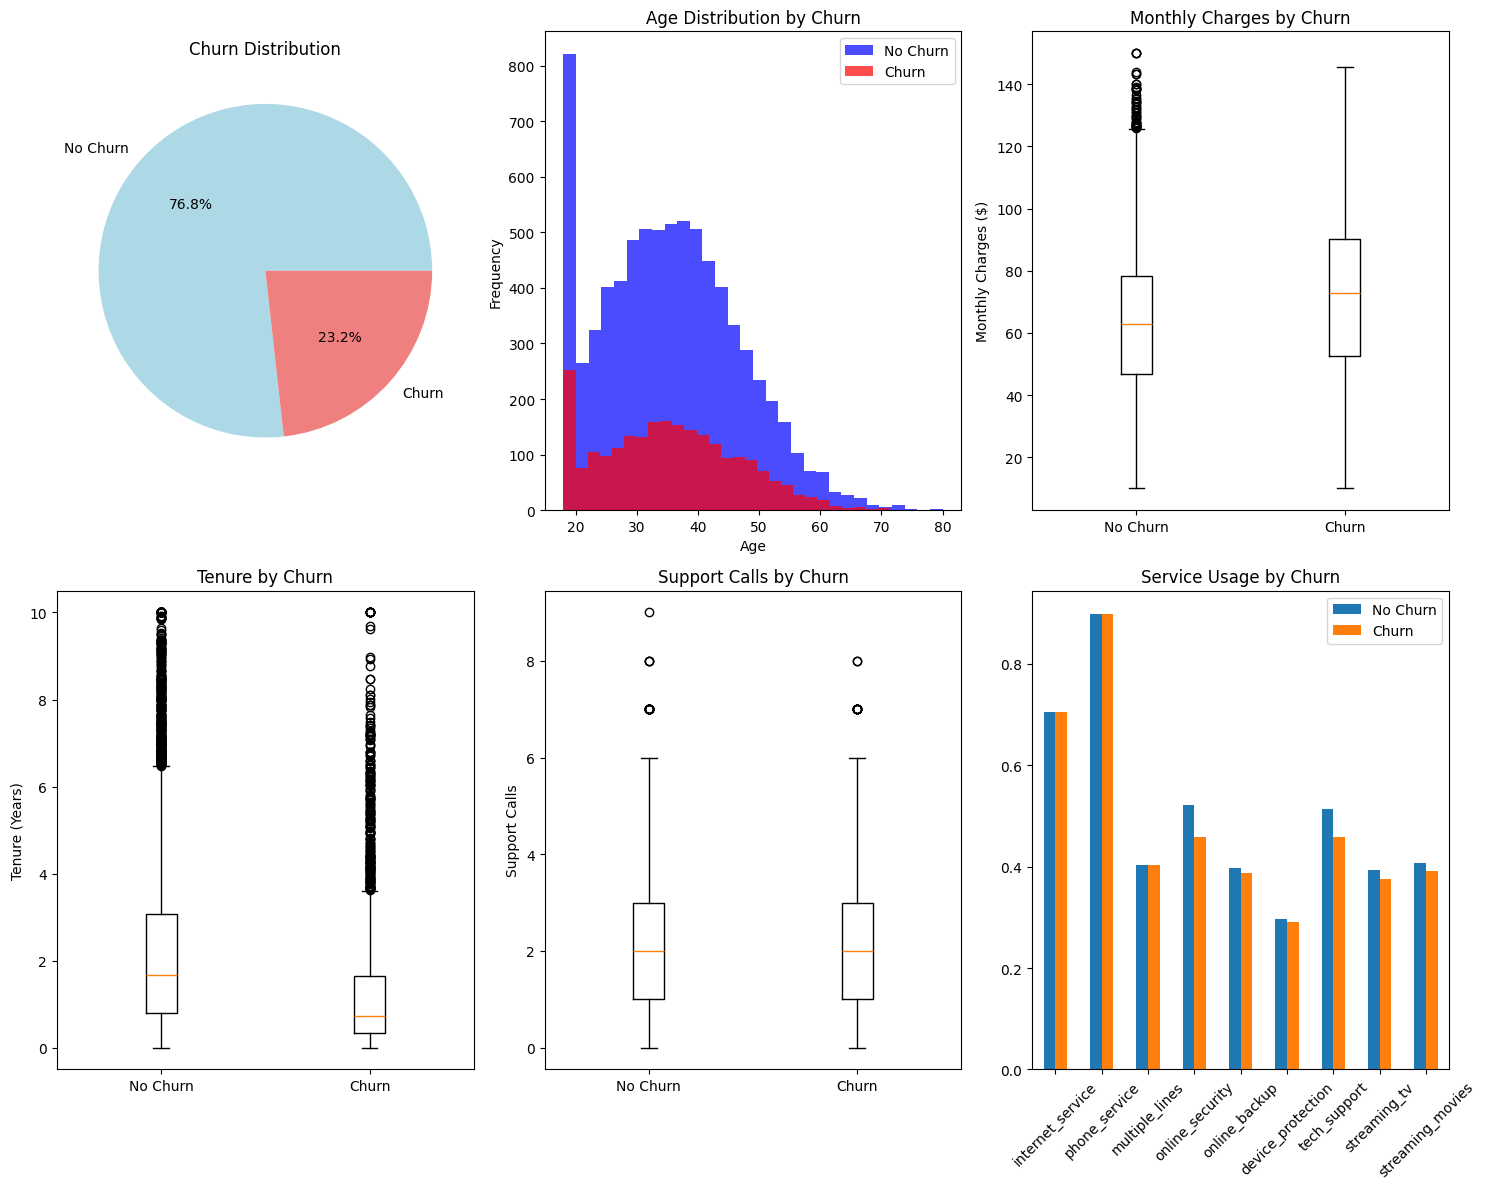

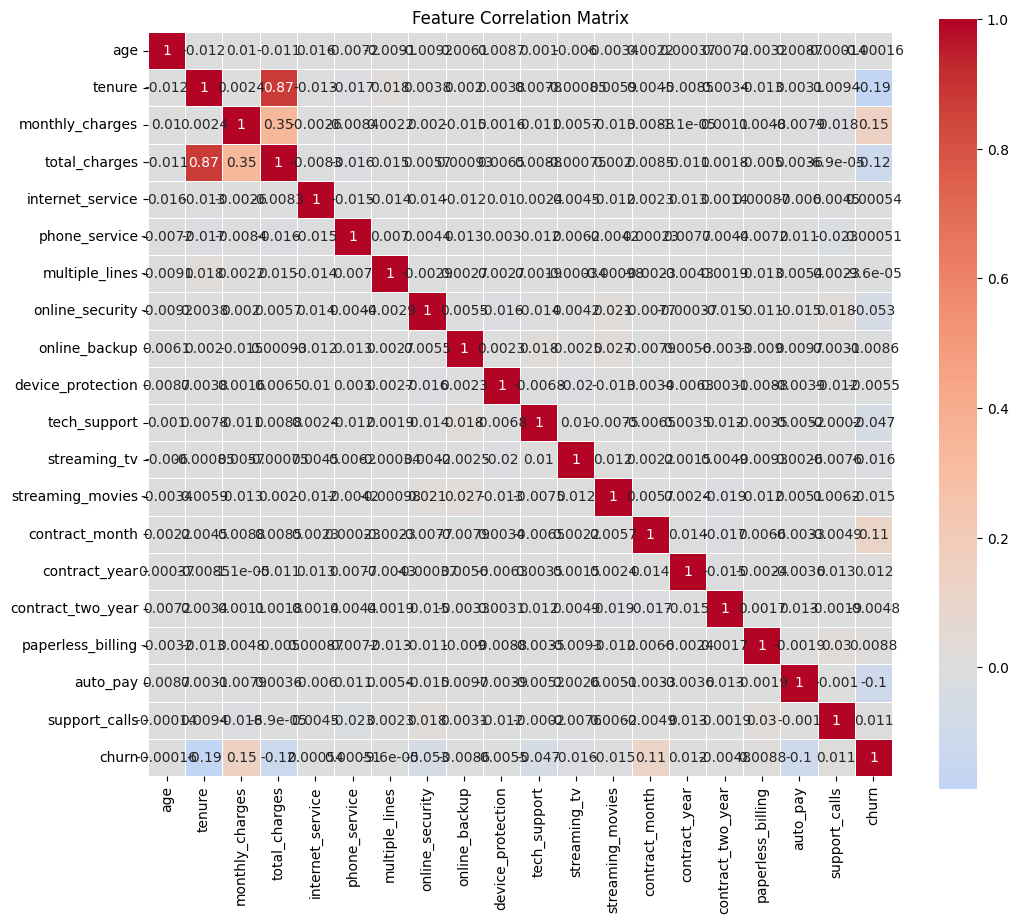

In [33]:
# ==============================
# EXPLORATORY DATA ANALYSIS
# ==============================
print("\n Exploratory Data Analysis")
print("-" * 40)

# Basic info
print("Dataset Info:")
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

# Churn distribution
plt.figure(figsize=(15, 12))

# 1. Churn distribution
plt.subplot(2, 3, 1)
churn_counts = df['churn'].value_counts()
plt.pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Churn Distribution')

# 2. Age distribution by churn
plt.subplot(2, 3, 2)
plt.hist(df[df['churn']==0]['age'], bins=30, alpha=0.7, label='No Churn', color='blue')
plt.hist(df[df['churn']==1]['age'], bins=30, alpha=0.7, label='Churn', color='red')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Churn')
plt.legend()

# 3. Monthly charges by churn
plt.subplot(2, 3, 3)
plt.boxplot([df[df['churn']==0]['monthly_charges'],
             df[df['churn']==1]['monthly_charges']],
            labels=['No Churn', 'Churn'])
plt.ylabel('Monthly Charges ($)')
plt.title('Monthly Charges by Churn')

# 4. Tenure by churn
plt.subplot(2, 3, 4)
plt.boxplot([df[df['churn']==0]['tenure'],
             df[df['churn']==1]['tenure']],
            labels=['No Churn', 'Churn'])
plt.ylabel('Tenure (Years)')
plt.title('Tenure by Churn')

# 5. Support calls by churn
plt.subplot(2, 3, 5)
plt.boxplot([df[df['churn']==0]['support_calls'],
             df[df['churn']==1]['support_calls']],
            labels=['No Churn', 'Churn'])
plt.ylabel('Support Calls')
plt.title('Support Calls by Churn')

# 6. Service usage correlation
plt.subplot(2, 3, 6)
service_cols = ['internet_service', 'phone_service', 'multiple_lines',
                'online_security', 'online_backup', 'device_protection',
                'tech_support', 'streaming_tv', 'streaming_movies']
service_churn = df[service_cols + ['churn']].groupby('churn').mean()
service_churn.T.plot(kind='bar', ax=plt.gca())
plt.title('Service Usage by Churn')
plt.xticks(rotation=45)
plt.legend(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [34]:
# ======================
# DATA PREPROCESSING
# ======================

print("\n Data Preprocessing")
print("-" * 40)

# Separate features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")


 Data Preprocessing
----------------------------------------
Training set size: 8000
Test set size: 2000
Training churn rate: 23.24%
Test churn rate: 23.25%


In [35]:
# ============================================================================
# MODEL TRAINING AND EVALUATION
# ============================================================================

print("\n Model Training and Evaluation")
print("-" * 40)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    # For SVM, use scaled data
    if name == 'SVM':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test

    # Train model
    model.fit(X_train_model, y_train)

    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='roc_auc')

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


 Model Training and Evaluation
----------------------------------------

🔹 Training Random Forest...
Accuracy: 0.7730
Precision: 0.5350
Recall: 0.1806
F1-Score: 0.2701
ROC-AUC: 0.7519
CV ROC-AUC: 0.7307 (+/- 0.0269)

🔹 Training XGBoost...
Accuracy: 0.7625
Precision: 0.4821
Recall: 0.2903
F1-Score: 0.3624
ROC-AUC: 0.7167
CV ROC-AUC: 0.7028 (+/- 0.0134)

🔹 Training SVM...
Accuracy: 0.7675
Precision: 0.5000
Recall: 0.0022
F1-Score: 0.0043
ROC-AUC: 0.6744
CV ROC-AUC: 0.6622 (+/- 0.0242)



 Model Comparison
----------------------------------------
           Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV ROC-AUC
0  Random Forest    0.7730     0.5350  0.1806    0.2701   0.7519      0.7307
1        XGBoost    0.7625     0.4821  0.2903    0.3624   0.7167      0.7028
2            SVM    0.7675     0.5000  0.0022    0.0043   0.6744      0.6622


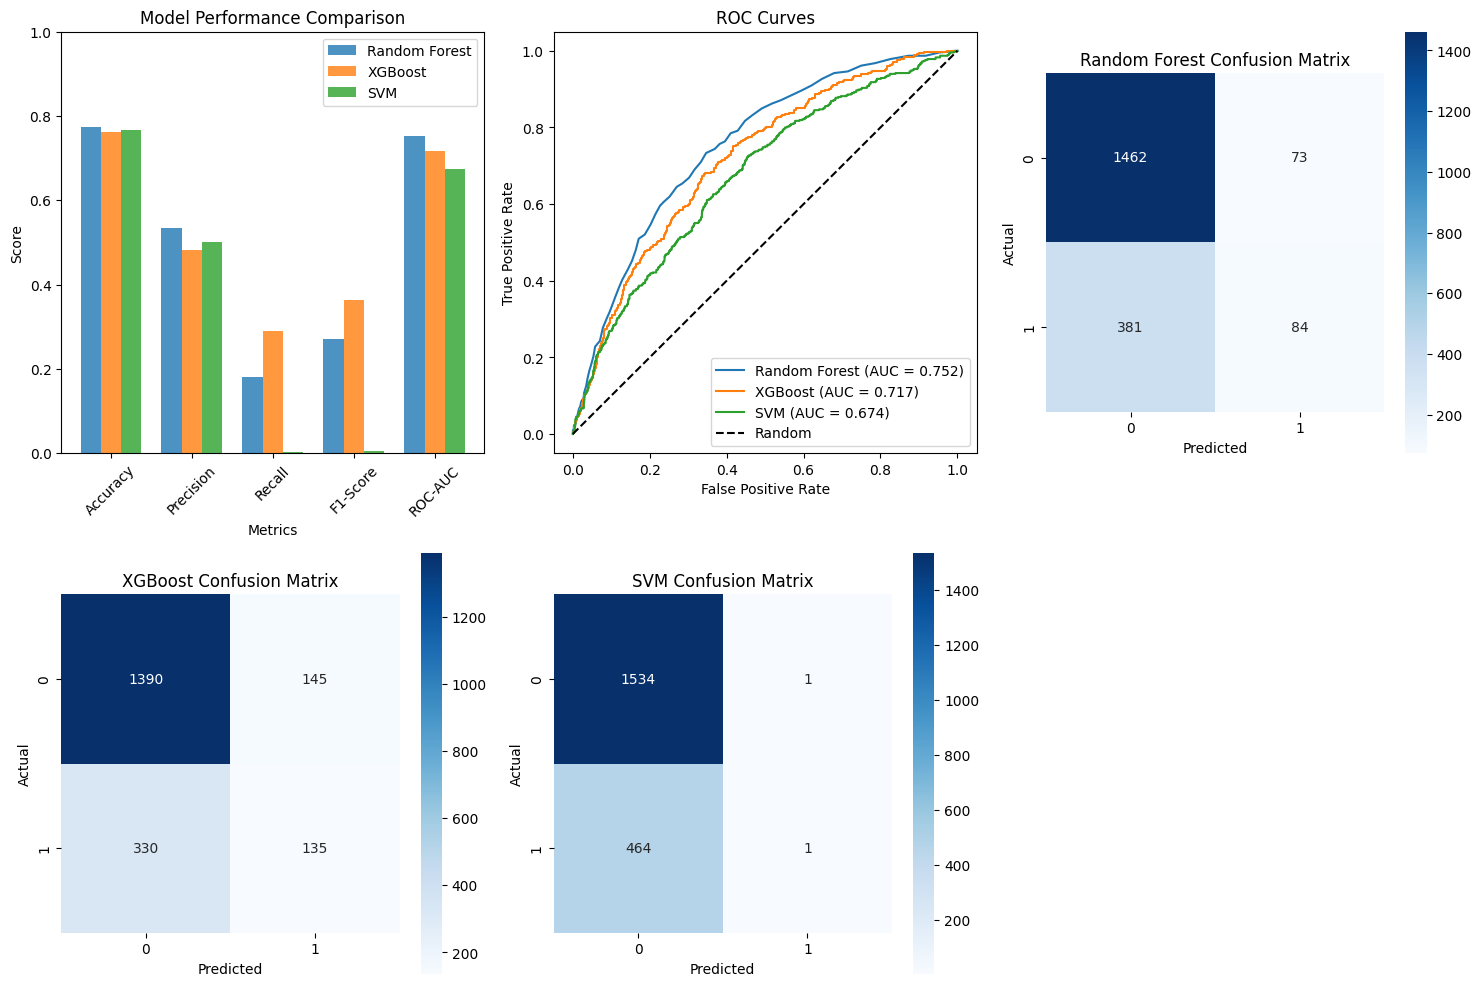

In [36]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================

print("\n Model Comparison")
print("-" * 40)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1'] for model in results.keys()],
    'ROC-AUC': [results[model]['roc_auc'] for model in results.keys()],
    'CV ROC-AUC': [results[model]['cv_mean'] for model in results.keys()]
})

print(comparison_df.round(4))

# Visualization
plt.figure(figsize=(15, 10))

# 1. Model comparison bar chart
plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(results.keys()):
    values = [
    results[model]['accuracy'],
    results[model]['precision'],
    results[model]['recall'],
    results[model]['f1'],
    results[model]['roc_auc']
]
    plt.bar(x + i * width, values, width, label=model, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, metrics, rotation=45)
plt.legend()
plt.ylim(0, 1)

# 2. ROC Curves
plt.subplot(2, 3, 2)
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# 3. Confusion matrices
for i, name in enumerate(results.keys()):
    plt.subplot(2, 3, i + 3)
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


 Feature Importance Analysis
----------------------------------------


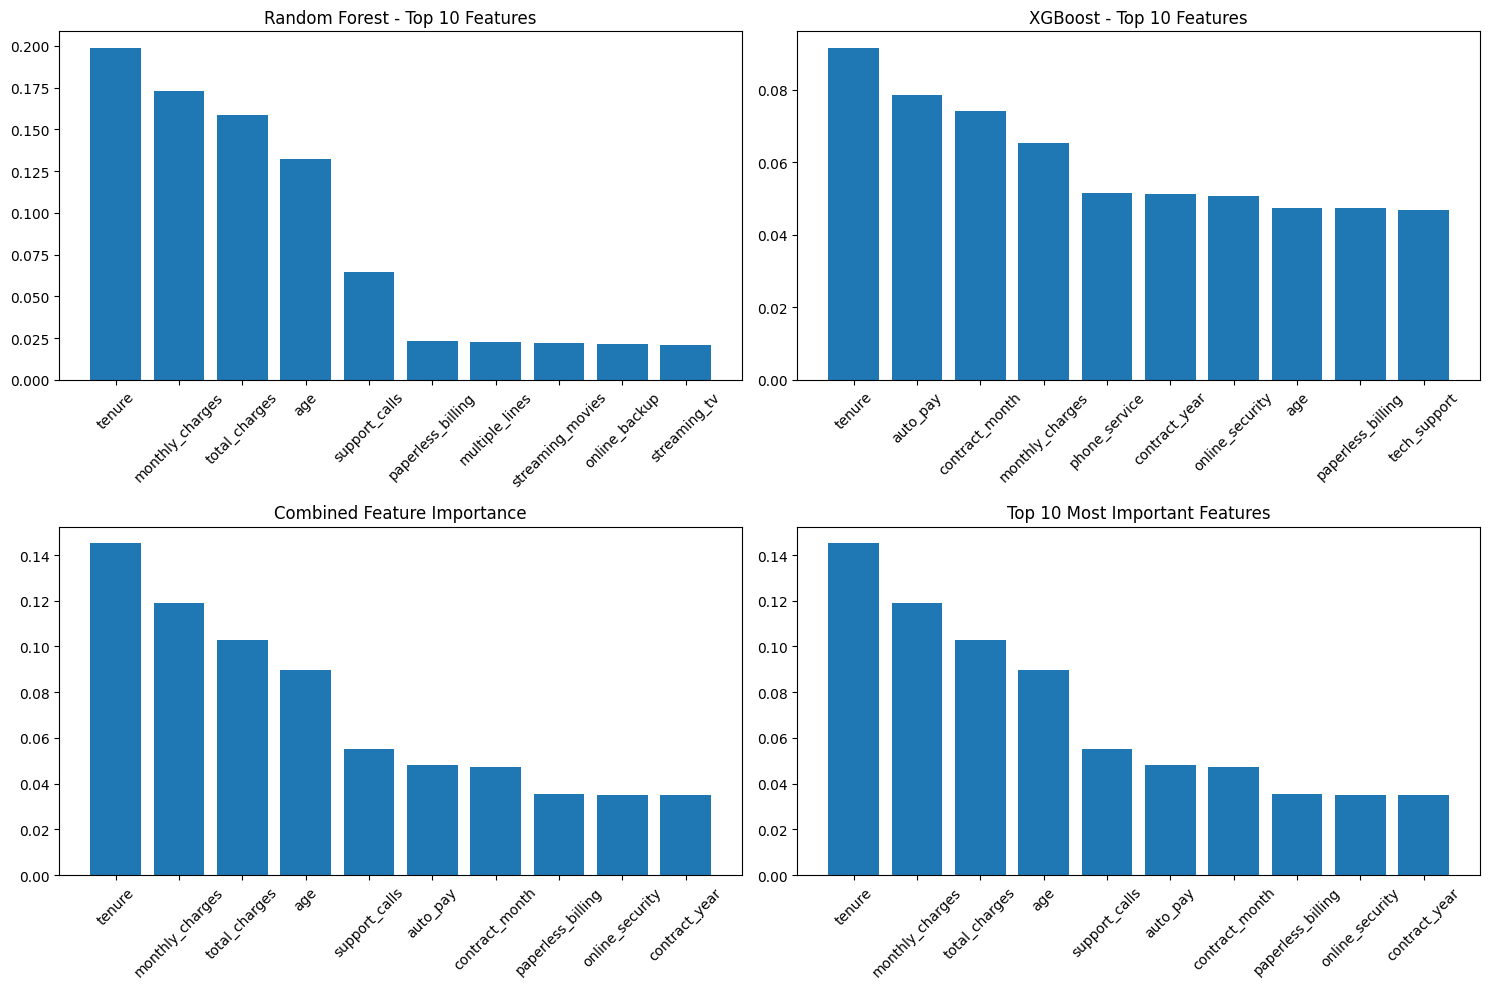


Top 10 Most Important Features:
              Feature  Random Forest  XGBoost  Combined
1              tenure         0.1988   0.0916    0.1452
2     monthly_charges         0.1732   0.0653    0.1192
3       total_charges         0.1588   0.0469    0.1028
0                 age         0.1322   0.0474    0.0898
18      support_calls         0.0643   0.0457    0.0550
17           auto_pay         0.0175   0.0785    0.0480
13     contract_month         0.0205   0.0742    0.0474
16  paperless_billing         0.0234   0.0473    0.0354
7     online_security         0.0194   0.0506    0.0350
14      contract_year         0.0187   0.0512    0.0350


In [37]:
# ============================================================================
# 6. FEATURE IMPORTANCE
# ============================================================================

print("\n Feature Importance Analysis")
print("-" * 40)

# Get feature importance for tree-based models
feature_names = X.columns

plt.figure(figsize=(15, 10))

# Random Forest feature importance
plt.subplot(2, 2, 1)
rf_importance = results['Random Forest']['model'].feature_importances_
rf_indices = np.argsort(rf_importance)[::-1][:10]
plt.bar(range(10), rf_importance[rf_indices])
plt.title('Random Forest - Top 10 Features')
plt.xticks(range(10), [feature_names[i] for i in rf_indices], rotation=45)

# XGBoost feature importance
plt.subplot(2, 2, 2)
xgb_importance = results['XGBoost']['model'].feature_importances_
xgb_indices = np.argsort(xgb_importance)[::-1][:10]
plt.bar(range(10), xgb_importance[xgb_indices])
plt.title('XGBoost - Top 10 Features')
plt.xticks(range(10), [feature_names[i] for i in xgb_indices], rotation=45)

# Combined importance
plt.subplot(2, 2, 3)
combined_importance = (rf_importance + xgb_importance) / 2
combined_indices = np.argsort(combined_importance)[::-1][:10]
plt.bar(range(10), combined_importance[combined_indices])
plt.title('Combined Feature Importance')
plt.xticks(range(10), [feature_names[i] for i in combined_indices], rotation=45)

# Feature importance table
plt.subplot(2, 2, 4)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance,
    'Combined': combined_importance
}).sort_values('Combined', ascending=False)

top_features = importance_df.head(10)
plt.bar(range(10), top_features['Combined'])
plt.title('Top 10 Most Important Features')
plt.xticks(range(10), top_features['Feature'], rotation=45)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).round(4))

In [38]:
# ============================================================================
# BUSINESS METRICS AND INSIGHTS
# ============================================================================

print("\n Business Metrics and Insights")
print("-" * 40)

# Calculate business metrics
def calculate_business_metrics(y_true, y_pred, y_pred_proba):
    """Calculate business-relevant metrics"""

    # Assumptions for business calculations
    avg_monthly_revenue = 65  # Average monthly revenue per customer
    customer_lifetime_months = 24  # Average customer lifetime
    retention_cost = 50  # Cost to retain a customer
    acquisition_cost = 200  # Cost to acquire a new customer

    # Basic confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Business metrics
    total_customers = len(y_true)
    actual_churners = sum(y_true)
    predicted_churners = sum(y_pred)

    # Revenue calculations
    customer_lifetime_value = avg_monthly_revenue * customer_lifetime_months

    # Prevented churn (True Positives)
    prevented_churn_value = tp * customer_lifetime_value

    # Wasted retention efforts (False Positives)
    wasted_retention_cost = fp * retention_cost

    # Missed opportunities (False Negatives)
    missed_opportunity_cost = fn * customer_lifetime_value

    # Net business impact
    retention_campaign_cost = predicted_churners * retention_cost
    total_benefit = prevented_churn_value - retention_campaign_cost

    return {
        'total_customers': total_customers,
        'actual_churners': actual_churners,
        'predicted_churners': predicted_churners,
        'correctly_identified': tp,
        'prevented_churn_value': prevented_churn_value,
        'wasted_retention_cost': wasted_retention_cost,
        'missed_opportunity_cost': missed_opportunity_cost,
        'retention_campaign_cost': retention_campaign_cost,
        'total_benefit': total_benefit,
        'roi': (total_benefit / retention_campaign_cost) * 100 if retention_campaign_cost > 0 else 0
    }

# Calculate business metrics for each model
business_results = {}
for name in results.keys():
    business_results[name] = calculate_business_metrics(
        y_test,
        results[name]['y_pred'],
        results[name]['y_pred_proba']
    )

# Display business metrics
business_df = pd.DataFrame(business_results).T
print("\nBusiness Impact Analysis:")
print(business_df.round(2))

# Visualization of business metrics
plt.figure(figsize=(15, 10))


 Business Metrics and Insights
----------------------------------------

Business Impact Analysis:
               total_customers  actual_churners  predicted_churners  \
Random Forest           2000.0            465.0               157.0   
XGBoost                 2000.0            465.0               280.0   
SVM                     2000.0            465.0                 2.0   

               correctly_identified  prevented_churn_value  \
Random Forest                  84.0               131040.0   
XGBoost                       135.0               210600.0   
SVM                             1.0                 1560.0   

               wasted_retention_cost  missed_opportunity_cost  \
Random Forest                 3650.0                 594360.0   
XGBoost                       7250.0                 514800.0   
SVM                             50.0                 723840.0   

               retention_campaign_cost  total_benefit      roi  
Random Forest                   7850.0  

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

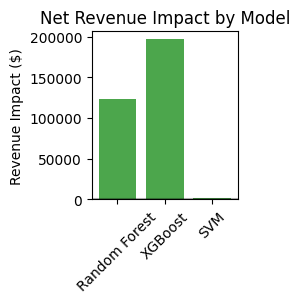

In [39]:
# Revenue Impact
plt.subplot(2, 3, 1)
models_list = list(business_results.keys())
revenue_impact = [business_results[model]['total_benefit'] for model in models_list]
colors = ['green' if x > 0 else 'red' for x in revenue_impact]
plt.bar(models_list, revenue_impact, color=colors, alpha=0.7)
plt.title('Net Revenue Impact by Model')
plt.ylabel('Revenue Impact ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

([0, 1, 2],
 [Text(0, 0, 'Random Forest'), Text(1, 0, 'XGBoost'), Text(2, 0, 'SVM')])

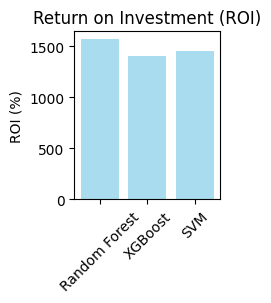

In [40]:
# ROI Comparison
plt.subplot(2, 3, 2)
roi_values = [business_results[model]['roi'] for model in models_list]
plt.bar(models_list, roi_values, color='skyblue', alpha=0.7)
plt.title('Return on Investment (ROI)')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45)

([0, 1, 2],
 [Text(0, 0, 'Random Forest'), Text(1, 0, 'XGBoost'), Text(2, 0, 'SVM')])

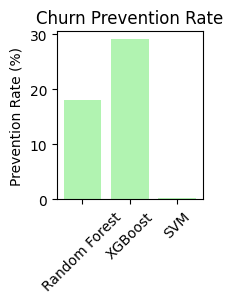

In [41]:
# Churn Prevention Effectiveness
plt.subplot(2, 3, 3)
prevented_churn = [business_results[model]['correctly_identified'] for model in models_list]
total_churn = business_results[models_list[0]]['actual_churners']
prevention_rate = [x/total_churn * 100 for x in prevented_churn]
plt.bar(models_list, prevention_rate, color='lightgreen', alpha=0.7)
plt.title('Churn Prevention Rate')
plt.ylabel('Prevention Rate (%)')
plt.xticks(rotation=45)

([0, 1, 2],
 [Text(0, 0, 'Random Forest'), Text(1, 0, 'XGBoost'), Text(2, 0, 'SVM')])

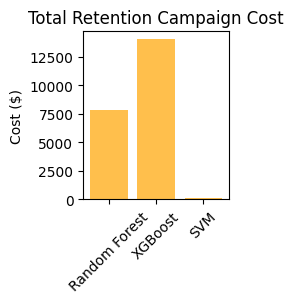

In [42]:
# Cost Analysis
plt.subplot(2, 3, 4)
retention_costs = [business_results[model]['retention_campaign_cost'] for model in models_list]
plt.bar(models_list, retention_costs, color='orange', alpha=0.7)
plt.title('Total Retention Campaign Cost')
plt.ylabel('Cost ($)')
plt.xticks(rotation=45)

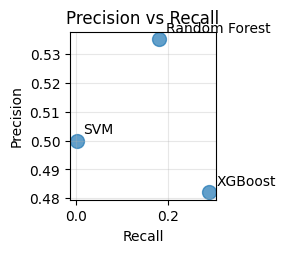

In [43]:
# Precision vs Recall Trade-off
plt.subplot(2, 3, 5)
precision_values = [results[model]['precision'] for model in models_list]
recall_values = [results[model]['recall'] for model in models_list]
plt.scatter(recall_values, precision_values, s=100, alpha=0.7)
for i, model in enumerate(models_list):
    plt.annotate(model, (recall_values[i], precision_values[i]),
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.grid(True, alpha=0.3)

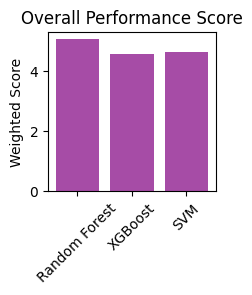

In [44]:
# Overall Performance Score
plt.subplot(2, 3, 6)
# Weighted score: 40% ROC-AUC, 30% ROI, 30% Prevention Rate
performance_scores = []
for model in models_list:
    roc_weight = results[model]['roc_auc'] * 0.4
    roi_weight = (business_results[model]['roi'] / 100) * 0.3
    prevention_weight = (business_results[model]['correctly_identified'] /
                        business_results[model]['actual_churners']) * 0.3
    total_score = roc_weight + roi_weight + prevention_weight
    performance_scores.append(total_score)

plt.bar(models_list, performance_scores, color='purple', alpha=0.7)
plt.title('Overall Performance Score')
plt.ylabel('Weighted Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [45]:
# ============================================================================
# RECOMMENDATIONS AND INSIGHTS
# ============================================================================

print("\n Key Insights and Recommendations")
print("-" * 40)

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
best_business_model = max(business_results.keys(), key=lambda x: business_results[x]['total_benefit'])

print(f"   Best Technical Model: {best_model_name}")
print(f"   - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"   - F1-Score: {results[best_model_name]['f1']:.4f}")

print(f"\n Best Business Model: {best_business_model}")
print(f"   - Net Revenue Impact: ${business_results[best_business_model]['total_benefit']:,.2f}")
print(f"   - ROI: {business_results[best_business_model]['roi']:.1f}%")

print(f"\n  Dataset Insights:")
print(f"   - Total Customers: {len(df):,}")
print(f"   - Churn Rate: {df['churn'].mean():.2%}")
print(f"   - Average Monthly Revenue: ${df['monthly_charges'].mean():.2f}")
print(f"   - Average Tenure: {df['tenure'].mean():.1f} years")

print(f"\n  Key Churn Indicators:")
top_5_features = importance_df.head(5)['Feature'].tolist()
for i, feature in enumerate(top_5_features, 1):
    print(f"   {i}. {feature}")


 Key Insights and Recommendations
----------------------------------------
   Best Technical Model: Random Forest
   - ROC-AUC: 0.7519
   - F1-Score: 0.2701

 Best Business Model: XGBoost
   - Net Revenue Impact: $196,600.00
   - ROI: 1404.3%

  Dataset Insights:
   - Total Customers: 10,000
   - Churn Rate: 23.24%
   - Average Monthly Revenue: $65.01
   - Average Tenure: 2.0 years

  Key Churn Indicators:
   1. tenure
   2. monthly_charges
   3. total_charges
   4. age
   5. support_calls
